## Install and Import Libraries

In [2]:
# !python3 -m pip install opencv-python
# !python3 -m pip install imutils
# !python3 -m pip install scipy
# !python3 -m pip install kivymd

     |████████████████████████████████| 2.3 MB 183 kB/s eta 0:00:01
     |████████████████████████████████| 22.2 MB 115 kB/s eta 0:00:01
  Using cached kivy-garden-0.1.4.tar.gz (6.8 kB)
     |████████████████████████████████| 575 kB 130 kB/s eta 0:00:01
  Created wheel for Kivy-Garden: filename=Kivy_Garden-0.1.4-py3-none-any.whl size=4531 sha256=16b6d8bd3c63774dbc6c8a6f4ba33808b1f2aac529659bc284846bc7480bc181
  Stored in directory: /home/pouya/.cache/pip/wheels/d2/72/1a/9ddd17f00755707937caa350616965fb3330a6270425f397e6
Successfully built Kivy-Garden


In [167]:
import cv2
import dlib
from imutils import face_utils
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
import time
import os
import glob
from tqdm import tqdm
import pandas as pd
import seaborn as sns
sns.set()

## Extract Means from RGB Videos

In [2]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
# fa = face_utils.FaceAligner(predictor, desiredFaceWidth=256)

In [3]:
import cv2
import numpy as np

def get_buf(path):
    
    
    cap = cv2.VideoCapture(path)
    frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    ROI = np.zeros((frameCount, 10, 10, 3))
    
#     buf = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))

    fc = 0
    ret = True
    
#     fps = cap.get(cv2.CAP_PROP_FPS)
    
    while (fc < frameCount  and ret):
        ret, frame = cap.read()
        
        ROI[fc] = get_ROI(frame)
        
        fc += 1



    cap.release()
    
    return ROI

In [4]:
def get_ROI(frame):
    
    
    data_buffer = []
    bpms = []
    
        
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    rects = detector(gray, 0)

    if len(rects) > 0:

        # converting opencv Rectangle object to tuple
        (x, y, w, h) = face_utils.rect_to_bb(rects[0])

        # drawing face bounding box on screen
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

        face_frame = frame[y: y + h, x: x + w]


        grayf = cv2.cvtColor(face_frame, cv2.COLOR_BGR2GRAY)
        shape = predictor(grayf, rects[0])
        shape = face_utils.shape_to_np(shape)

        ROI1_detected = frame[shape[29][1]:shape[33][1], shape[54][0]: shape[12][0]]
        ROI2_detected = frame[shape[29][1]:shape[33][1], shape[4][0]: shape[48][0]]


        y_start, y_end = ROI1_detected.shape[0] // 2 - 5, ROI1_detected.shape[0] // 2 + 5
        x_start, x_end = ROI1_detected.shape[1] // 2 - 5, ROI1_detected.shape[1] // 2 + 5

        ROI1_selected = ROI1_detected[y_start: y_end, x_start: x_end]


        y_start, y_end = ROI2_detected.shape[0] // 2 - 5, ROI2_detected.shape[0] // 2 + 5
        x_start, x_end = ROI2_detected.shape[1] // 2 - 5, ROI2_detected.shape[1] // 2 + 5

        ROI2_selected = ROI2_detected[y_start: y_end, x_start: x_end]

        return (ROI1_selected + ROI2_selected) / 2

In [7]:
for session in tqdm(os.listdir("./dataset")[35:100]):
    
    if len(glob.glob('./dataset/{}/*.npy'.format(session))) > 0:
        continue
    
    video = glob.glob("./dataset/{}/*.avi".format(session))[0]
    
    ROI = get_buf(video)
    
    channel_means = ROI.mean(axis=(1, 2))
#     print(ROI.shape)
#     channel_means = get_ROI(buf, fps)
    
#     print(channel_means.shape)
    
    np.save("./dataset/{}/{}.npy".format(session, session), channel_means) 

100%|██████████| 65/65 [5:47:22<00:00, 320.66s/it]  


## Get BPMS

In [186]:
# implementing Realt Time Heart Rate Monitoring From Facial RGB Color Video Using Webcam H.Rahman, M.U Ahmed

def process(data_buffer, times):
    
    
    """
    Detrending
    Remove unwanted trend from series
    the collected RGB signals will be drfting and noising
    
    """
    data_buffer = signal.detrend(data_buffer, axis=0)
    
    
    # Filtering
    filter_ = np.hamming(len(data_buffer)) * 1.4 + 0.6
#     filter_ = filter_.reshape(128, 1)
    x_filtered = filter_ * data_buffer
    
    # Normalization
#     data_buffer_normalized = (x_filtered - x_filtered.mean()) \
#                                     / x_filtered.std()
    
    
    data_buffer_normalized = x_filtered / np.linalg.norm(x_filtered)
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8))
    
    
    ax1.plot(data_buffer, c="g")
    ax1.set_title("Input Signal")
    ax1.set_xlabel("Time(frame)")
    ax1.set_ylabel("Color intensity")
    
#     plt.figure()
    ax2.plot(data_buffer_normalized, c="g")
    ax2.set_title("Normalized Signal")
    ax2.set_xlabel("Time(frame)")
    ax2.set_ylabel("Signal Strength")
#     fastICA = FastICA()
#     ica = fastICA.fit_transform(data_buffer_normalized.reshape(-1, 1))
    
#     plt.figure()
#     plt.plot(ica)
    
    
    fft = np.fft.fft(data_buffer_normalized)
    fft = np.abs(fft) ** 2
    
    duration = (times[-1] - times[0])
    
    N = len(times)
    
    T = (times[-1] - times[0]) / N
    
    xt = np.linspace(0.0, 1.0/(2.0*T), N/2)
    yt = (2.0/N) * np.abs(fft[:N//2])
    
    selected_freq = (xt > 0.75) & (xt < 4.6)
    
#     plt.figure()
    ax3.plot(xt[selected_freq], yt[selected_freq], c='g')
    ax3.set_title("FFT Applied")
    
    ax3.set_xlabel("Frequency(Hz)")
    ax3.set_ylabel("Power")
    
    fig.tight_layout()
        
#     plt.plot(times_, fft[selected_freq][:])

#     plt.plot(times, fft)
     
    bpm_counting = len(signal.find_peaks(yt[selected_freq][:])[0]) / (times[-1] - times[0]) * 60
    
    idx = np.argmax(yt[selected_freq])
    bpm_max = 1  / xt[selected_freq][idx] * 60
    
#     bpm = len(signal.find_peaks(yt[selected_freq])[0]) / (times[-1] - times[0]) * 60
    
    return (bpm_counting, bpm_max)

(54.995871180842286, 74.12244897959182)

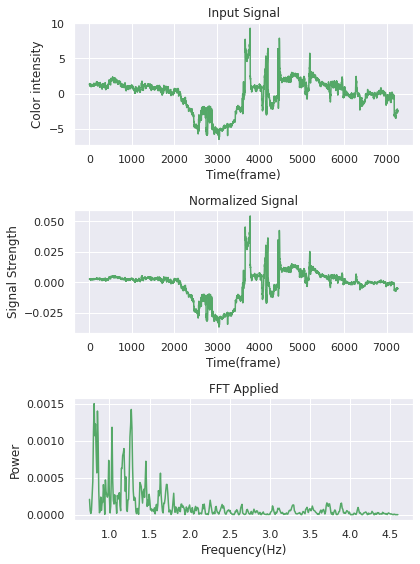

In [187]:
channel_means = np.load("./dataset/2/2.npy")
    
fps = 60
times = np.linspace(0, len(channel_means) / fps, len(channel_means))

process(channel_means[:, 1], times)

In [6]:
# Measuring Heart Rate From Video Isabel Bush Stanford

# def process1(data_buffer):
    
#     length = times[-1] - times[0]

#     fps = len(data_buffer) / length
    
#     detrend = signal.detrend(data_buffer.mean(axis=1))

#     normalized = (detrend - detrend.mean()) / detrend.std() 

#     filtered = (np.hamming(buffer_size) * 1.4 + 0.6) * normalized 

#     fft = np.fft.rfft(filtered)
    
# #     plt.plot(fft)
    
#     peaks_index = signal.find_peaks(fft)[0] 
    
#     peaks_in_range = np.sum((fft[peaks_index] > 0.75) & (fft[peaks_index] < 4)) 
    
#     print((peaks_in_range / length) * 60)

#     times_ = np.array(times)
    
#     times__ = times_[(times_ > 0.75) & (times_ < 4)]

#     fft_red = fft[:, 0][(times_ > 0.75) & (times_ < 4)]
#     fft_green = fft[:, 1][(times_ > 0.75) & (times_ < 4)]
#     fft_blue = fft[:, 2][(times_ > 0.75) & (times_ < 4)]

#     bpms.append(times__[np.argmax(fft_red)] * 60)
#     bpms.append(times__[np.argmax(fft_green)] * 60)
#     print(np.array(bmps[-30:]).mean())
    # print(times[np.argmax(fft_blue)] * 60)

In [146]:
df = pd.read_csv("./bpm_dataset.csv", index_col=0)
df

,bpm
2,73.210177
532,84.185578
788,60.418617
132,73.083565
924,74.469018
...,...
916,74.895302
140,78.919125
560,82.312961
938,77.959344


In [147]:
bpm_counting_column = []
bpm_max_column = []
sessions = []
for session in df.index:
    
    if not os.path.exists("./dataset/{}/{}.npy".format(session, session)):
        continue
    
    channel_means = np.load("./dataset/{}/{}.npy".format(session, session))
    
    
    fps = 60
    times = np.linspace(0, len(channel_means) / fps, len(channel_means))
    
    bpm_counting, bpm_max = process(channel_means[:, 1], times)
    
    sessions.append(session)
    bpm_counting_column.append(bpm_counting)
    bpm_max_column.append(bpm_max)
    

In [150]:
df_processed = df[df.index.isin(sessions)]

In [151]:
df_processed["bpm max"] = bpm_max_column
df_processed["bpm counting"] = bpm_counting_column
df_processed

<ipython-input-151-d4491640941e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed["bpm max"] = bpm_max_column
<ipython-input-151-d4491640941e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed["bpm counting"] = bpm_counting_column


,bpm,bpm max,bpm counting
2,73.210177,74.122449,54.995871
532,84.185578,61.022901,67.083542
788,60.418617,56.586466,71.722672
132,73.083565,50.306011,75.847089
924,74.469018,51.932203,79.095062
...,...,...,...
26,68.666707,76.790698,64.840321
1304,88.533887,75.009174,73.945470
1338,92.869258,73.956989,70.106089
1328,88.807166,68.983871,74.053296


In [152]:
df_processed.to_csv("df_processed.csv")

In [154]:
df_processed

,bpm,bpm max,bpm counting
2,73.210177,74.122449,54.995871
532,84.185578,61.022901,67.083542
788,60.418617,56.586466,71.722672
132,73.083565,50.306011,75.847089
924,74.469018,51.932203,79.095062
...,...,...,...
26,68.666707,76.790698,64.840321
1304,88.533887,75.009174,73.945470
1338,92.869258,73.956989,70.106089
1328,88.807166,68.983871,74.053296


In [155]:
def outlier(row):
    row["outlier"] = (abs(row["bpm"] - row["bpm max"])) > 10
    
    return row

df_processed = df_processed.apply(outlier, axis=1)

In [160]:
df_inlier = df_processed[df_processed["outlier"] == 0.0]

Text(0, 0.5, 'predicted')

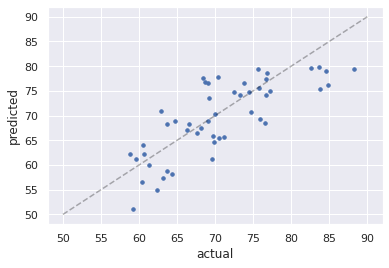

In [221]:
plt.scatter(df_inlier["bpm"], df_inlier["bpm max"], alpha=1, s=12)
plt.plot([50, 90], [50, 90], ls="--", c='black', alpha=0.3)
plt.xlabel("actual")
plt.ylabel("predicted")

In [220]:
np.sqrt(np.mean((df_inlier["bpm"] - df_inlier["bpm max"] ) ** 2))

5.064088819973432